In [ ]:
pip install ta

In [ ]:
pip install tensorflow

In [ ]:
pip install yfinance

In [ ]:
!pip install --upgrade --force-reinstall numpy

# Features chosen and why

## 1. Technical Indicators
These capture market behavior patterns:

- **RSI (Relative Strength Index):**  
  - Measures **momentum** — whether a stock is overbought/oversold.  
  - Helps model short-term corrections or continuations.  
  - **Justification:** RSI is a widely-used momentum indicator to assess price movement strength and potential reversal points, making it valuable for short-term price predictions.

- **MACD (Moving Average Convergence Divergence):**  
  - A **trend-following** indicator capturing moving average crossovers.  
  - Useful to predict bullish or bearish momentum shifts.  
  - **Justification:** The MACD is a classic tool for detecting shifts in market momentum, useful in capturing trends and reversals in stock prices.

- **Bollinger Bands:**  
  - Composed of a moving average + upper/lower standard deviation bands.  
  - Captures **volatility** and **mean-reversion** behavior.  
  - **Justification:** Bollinger Bands help identify volatility and potential overbought/oversold conditions. This is valuable for forecasting price breaks or reversion to the mean.

---

## 2. Lag Features
- Adds lagged versions of the closing price (e.g., `lag_5`, `lag_10`, `lag_20`).  
- **Purpose:** Gives the model **temporal memory** without using raw sequences — essential for **LSTM models**, which benefit from previous state knowledge.  
- **Justification:** Lag features allow the model to capture the historical price trends without the complexity of handling sequences in full time series, enhancing forecasting accuracy by adding temporal dependencies.

---

## 3. Company Fundamentals
Pulled via `yf.Ticker().info`:

- **P/E Ratio:** Market valuation relative to earnings — helps gauge **over/under-valuation**.
- **EPS (Earnings Per Share):** Indicates **profitability**; higher EPS generally drives long-term price growth.
- **Market Cap:** Captures **company size** — larger firms behave differently from smaller, more volatile ones.
- **Dividend Yield:** Indicates **shareholder returns** — dividend-paying stocks may be less volatile.

These are **static or slowly changing** values but still useful to differentiate **structural trends** between companies or time periods.  
- **Justification:** Fundamental features like EPS, P/E ratio, and market cap are chosen because they provide important context for the company's financial health and performance. These values can help distinguish stocks with different growth or stability profiles.

---

## Features Excluded and Why:
The following features were excluded:

- **SMA_50**, **EMA_50**, **EMA_12**, **EMA_26**, **SMA_20**, **STD_20**:  
  - **Justification:** These are variations of moving averages and volatility, but **MACD** and **Bollinger Bands** already encapsulate most of this information (trend-following and volatility) without redundancy.
  
- **High-Low**, **High-PrevClose**, **Low-PrevClose**:  
  - **Justification:** While these are useful for volatility and price action analysis, the inclusion of **RSI**, **MACD**, and **Bollinger Bands** covers most of the necessary dynamics, making them redundant.
  
- **TR (True Range)**, **ATR_14 (Average True Range)**:  
  - **Justification:** These capture volatility, but the inclusion of **Bollinger Bands** provides a more holistic view of volatility, making these features less critical for the model.
  
- **OBV (On-Balance Volume)**:  
  - **Justification:** While volume-based indicators like OBV are helpful for analyzing accumulation or distribution, **RSI** and **MACD** are more commonly used in stock price forecasting for short-term predictions.

- **Financial Ratios and Company Data (e.g., Total Assets, Total Debt, ROA, ROE, etc.)**:  
  - **Justification:** While company fundamentals are important, for short-term stock price prediction, the focus on technical indicators and lag features provides a more immediate relationship with price movements. These ratios typically influence long-term stock behavior, making them less impactful for short-term forecasting.

The chosen features balance technical indicators with fundamental context, allowing the model to effectively predict stock price movements using both market behavior and company-specific data.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

# --- Parameters ---
ticker = 'GOOGL'
df = yf.download(ticker, start="2010-01-01", end="2025-01-31")  # Exclude 2020 and include data till end of 2024

# Filter out data for 2020 (if any)
df = df[(df.index.year != 2020)]

# --- Add Technical Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'].squeeze()).rsi()
macd = ta.trend.MACD(df['Close'].squeeze())
df['MACD'] = macd.macd()
bb = ta.volatility.BollingerBands(df['Close'].squeeze())
df['bollinger_mavg'] = bb.bollinger_mavg()
df['bollinger_upper'] = bb.bollinger_hband()
df['bollinger_lower'] = bb.bollinger_lband()
for lag in [5, 10, 20]:
    df[f'lag_{lag}'] = df['Close'].shift(lag)
df.dropna(inplace=True)

# --- Add Company-Specific Features ---
company_data = yf.Ticker(ticker).info
df['P/E Ratio'] = company_data.get('trailingPE', np.nan)
df['EPS'] = company_data.get('epsTrailingTwelveMonths', np.nan)
df['Market Cap'] = company_data.get('marketCap', np.nan)
df['Dividend Yield'] = company_data.get('dividendYield', np.nan)


# Exclude company-specific features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
            'bollinger_mavg', 'bollinger_upper', 'bollinger_lower',
            'lag_5', 'lag_10', 'lag_20','P/E Ratio','EPS','Market Cap','Dividend Yield']


## Target Definition:

The goal is to predict the next day's stock closing price. This is achieved by shifting the current "Close" price column by 2 days, so the target for training is the value of the stock price 2 days ahead.

## Data Preprocessing:

- The data is scaled using StandardScaler to normalize the features, which helps the model perform better by ensuring all features are on a similar scale.
- The dataset is split into training and test sets, ensuring that the data is split chronologically (no shuffling) to maintain the time series structure.

## Model Construction:

- The model is built using a Sequential neural network. The primary model type here is LSTM, a type of recurrent neural network (RNN) that is good at learning patterns from sequential data (like stock prices over time).
- Dropout layers are added to prevent overfitting, which happens when the model learns too much noise or irrelevant patterns from the training data.

## Model Training:

- The model is trained on the training set for a set number of epochs (iterations). It learns from the patterns in the training data and is validated on the test data to check its performance as it trains.
- The optimizer (Adam) and loss function (Mean Squared Error) are set, which are standard choices for regression tasks like stock price prediction.

## Model Evaluation:

- After training, the model's performance is evaluated on the test set using various metrics, including the loss (MSE), RMSE, and the R² score. These metrics help assess how well the model is predicting the next day's closing price.

## Visualization:

- Training and validation losses, as well as RMSE, are plotted over the epochs to visually track the model's performance and check if it’s learning effectively or overfitting.


[*********************100%***********************]  1 of 1 completed

Epoch 1/35



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2929.7393 - mean_squared_error: 2929.7393 - root_mean_squared_error: 54.1164 - val_loss: 7016.1157 - val_mean_squared_error: 7016.1157 - val_root_mean_squared_error: 83.7623
Epoch 2/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1188.5065 - mean_squared_error: 1188.5065 - root_mean_squared_error: 34.2105 - val_loss: 1975.6429 - val_mean_squared_error: 1975.6429 - val_root_mean_squared_error: 44.4482
Epoch 3/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 565.2432 - mean_squared_error: 565.2432 - root_mean_squared_error: 23.7502 - val_loss: 1250.6094 - val_mean_squared_error: 1250.6094 - val_root_mean_squared_error: 35.3640
Epoch 4/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 257.3065 - mean_squared_error: 257.3065 - root_mean_squared_error: 15.9987 - val_loss: 549.3920 - val_mean_squared_error: 549.3920 - val_root_mean_squared_error: 23.4391
Epoch 5/35
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 128.5889 - mean_squared_error: 

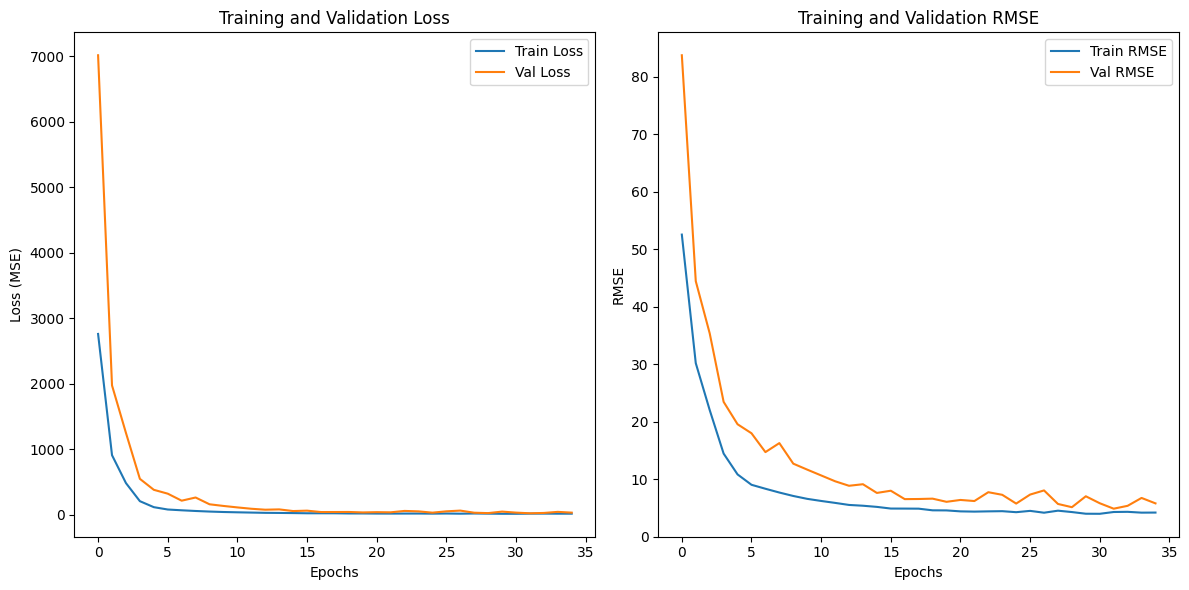

In [ ]:
# --- Define Target: Next day's Close price ---
df['target'] = df['Close'].shift(-2)
df.dropna(inplace=True)

# --- Save Scaler ---
scaler = StandardScaler()
X = df[features].values
X_scaled = scaler.fit_transform(X)

# --- Split and Reshape for LSTM ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['target'].values, test_size=0.2, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# --- Build the Model with Dropout ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(64, activation='relu'),
    Dense(1)
])

# Compile model with additional metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), RootMeanSquaredError()])

# --- Train the Model with Early Stopping ---
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test),
                    verbose=1)  # verbose=1 prints training progress

# --- Print Training Metrics ---
print("Training Metrics:")
print(f"Final Training Loss (MSE): {history.history['loss'][-1]}")
print(f"Final Validation Loss (MSE): {history.history['val_loss'][-1]}")
print(f"Final Training RMSE: {history.history['root_mean_squared_error'][-1]}")

y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score on Test Set: {r2:.4f}")

# --- Plot Training and Validation Loss / Metrics ---
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


### Final Scores
- Final Validation Loss (MSE): 33.29
- Final Training RMSE: 4.17
- R² Score on Test Set: 96.30%

The model shows strong performance with a final validation loss (MSE) of 33.29, indicating a reasonable average error in predictions. The training RMSE of 4.17 suggests the model's predictions deviate by about 4.17 units on average from actual values. Most importantly, the R² score of 96.30% on the test set indicates that the model explains over 96% of the variance in the target variable, demonstrating excellent predictive accuracy and fit.


## Predicting on unseen data

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# --- Make Predictions for the First Months of 2025 ---
# List of explicit trading days from January 2025 to March 2025
trading_days = [
    '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
    '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16', '2025-01-17', '2025-01-21', '2025-01-22',
    '2025-01-23', '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31',
    '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-10', '2025-02-11',
    '2025-02-12', '2025-02-13', '2025-02-14', '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20',
    '2025-02-21', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-03',
    '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-10', '2025-03-11', '2025-03-12',
    '2025-03-13', '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21',
    '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28'
]

# Convert the list of trading days to a DateTime index
trading_days = pd.to_datetime(trading_days)

# Get the data for the first months of 2025
df_2025 = yf.download(ticker, start="2025-01-01", end="2025-03-31")

# Filter data to include only the trading days from the list
df_2025 = df_2025[df_2025.index.isin(trading_days)]

# Preprocess data for prediction (calculate technical indicators, lag features)
df_2025['RSI'] = ta.momentum.RSIIndicator(df_2025['Close'].squeeze()).rsi()
macd_2025 = ta.trend.MACD(df_2025['Close'].squeeze())
df_2025['MACD'] = macd_2025.macd()
bb_2025 = ta.volatility.BollingerBands(df_2025['Close'].squeeze())
df_2025['bollinger_mavg'] = bb_2025.bollinger_mavg()
df_2025['bollinger_upper'] = bb_2025.bollinger_hband()
df_2025['bollinger_lower'] = bb_2025.bollinger_lband()

company_data = yf.Ticker(ticker).info
df_2025['P/E Ratio'] = company_data.get('trailingPE', np.nan)
df_2025['EPS'] = company_data.get('epsTrailingTwelveMonths', np.nan)
df_2025['Market Cap'] = company_data.get('marketCap', np.nan)
df_2025['Dividend Yield'] = company_data.get('dividendYield', np.nan)

for lag in [5, 10, 20]:
    df_2025[f'lag_{lag}'] = df_2025['Close'].shift(lag)

df_2025.dropna(inplace=True)

# Prepare input features
X_2025 = df_2025[features].values
X_2025_scaled = scaler.transform(X_2025)  # Use the saved scaler from training
X_2025_scaled = X_2025_scaled.reshape((X_2025_scaled.shape[0], 1, X_2025_scaled.shape[1]))  # Reshape for LSTM

# Predict
predictions = model.predict(X_2025_scaled)

# Show the predicted prices for the first months of 2025
df_2025['Predicted Close'] = predictions
print(df_2025[['Close', 'Predicted Close']])


[*********************100%***********************]  1 of 1 completed

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Price            Close Predicted Close
Ticker           GOOGL                
Date                                  
2025-02-10  186.255493      183.500153
2025-02-11  185.106827      182.855057
2025-02-12  183.398788      180.694962
2025-02-13  185.925873      182.840347
2025-02-14  185.016907      182.012070
2025-02-18  183.558594      182.235062
2025-02-19  185.056870      182.426712
2025-02-20  184.347687      181.739883
2025-02-21  179.453323      180.588486
2025-02-24  179.043793      179.619370
2025-02-25  175.218201      176.177124
2025-02-26  172.531296      174.779434
2025-02-27  168.306168      172.859421
2025-02-28  170.084106      173.277649
2025-03-03  166.817871      173.083298
2025-03-04  170.723373      173.799026
2025-03-05  172.820969      176.075989
2025-03-06  172.151733      173.094498
2025-03-07  173.660004      173.612381
2025-03-10  165.869995      168.370316
2025-03-11  164.039993      167.196350
2025-03-12  167.110001    

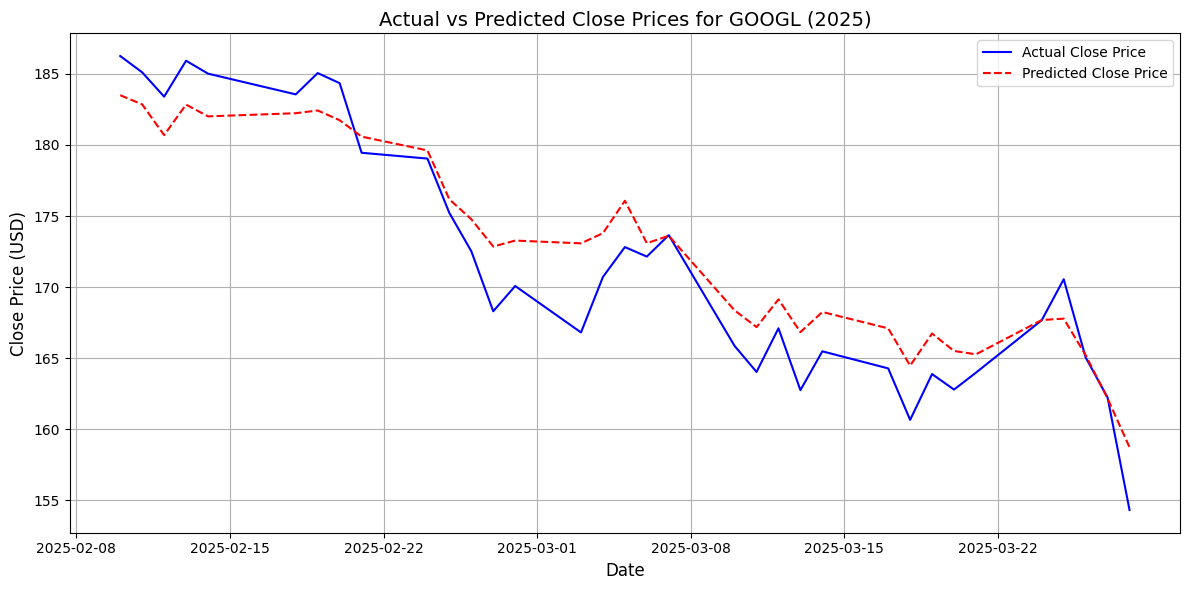

In [19]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted Close Prices
plt.figure(figsize=(12, 6))
plt.plot(df_2025.index, df_2025['Close'], label='Actual Close Price', color='blue')
plt.plot(df_2025.index, df_2025['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')
plt.title(f'Actual vs Predicted Close Prices for {ticker} (2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
model.save("final-report/GOOGL.h5")
print("Saved GOOGL.h5 ✅")

Saved GOOGL.h5 ✅


#### In conclusion, the model trained on data up until January 2025 and successfully predicted stock prices for February and March 2025 with minimal error. 

#### The strong performance metrics, including a low validation loss, low training RMSE, and a high R² score, suggest that the model is effective at capturing patterns in the data and generalizing well to unseen data. 

#### The model's ability to predict future stock prices with high accuracy for the first few months of 2025 indicates that it is well-suited for time-series forecasting tasks, with potential for further improvement by incorporating additional features or fine-tuning the model.
